[Sebastian Raschka](http://sebastianraschka.com)  

- [Open in IPython nbviewer](http://nbviewer.ipython.org/github/rasbt/python_reference/blob/master/tutorials/multiprocessing_intro.ipynb?create=1)  

- [Link to this IPython notebook on Github](https://github.com/rasbt/python_reference/blob/master/tutorials/multiprocessing_intro.ipynb)  

- [Link to the GitHub Repository python_reference](https://github.com/rasbt/python_reference)


In [1]:
import time
print('Last updated: %s' %time.strftime('%d/%m/%Y'))

Last updated: 20/06/2014


<hr>
I would be happy to hear your comments and suggestions.  
Please feel free to drop me a note via
[twitter](https://twitter.com/rasbt), [email](mailto:bluewoodtree@gmail.com), or [google+](https://plus.google.com/+SebastianRaschka).
<hr>

# Parallel processing via the `multiprocessing` module

CPUs with multiple cores have become the standard in the recent development of modern computer architectures and we can not only find them in supercomputer facilities but also in our desktop machines at home, and our laptops; even Apple's iPhone 5S got a 1.3 Ghz Dual-core processor in 2013.

However, the default Python interpreter was designed with simplicity in mind and has a thread-safe mechanism, the so-called "GIL" (Global Interpreter Lock). In order to prevent conflicts between threads, it executes only one statement at a time (so-called serial processing, or single-threading).

In this introduction to Python's `multiprocessing` module, we will see how we can spawn multiple subprocesses to avoid some of the GIL's disadvantages.

<br>
<br>

## Sections

- [An introduction to parallel programming using Python's `multiprocessing` module](#An-introduction-to-parallel-programming-using-Python's-`multiprocessing`-module)
    - [Multi-Threading vs. Multi-Processing](#Multi-Threading-vs.-Multi-Processing)
- [Introduction to the `multiprocessing` module](#Introduction-to-the-multiprocessing-module)
    - [The `Process` class](#The-Process-class)
        - [How to retrieve results in a particular order](#How-to-retrieve-results-in-a-particular-order)
    - [The `Pool` class](#The-Pool-class)
- [Kernel density estimation as benchmarking function](#Kernel-density-estimation-as-benchmarking-function)
    - [The Parzen-window method in a nutshell](#The-Parzen-window-method-in-a-nutshell)
    - [Sample data and `timeit` benchmarks](#Sample-data-and-timeit-benchmarks)
    - [Benchmarking functions](#Benchmarking-functions)
    - [Preparing the plotting of the results](#Preparing-the-plotting-of-the-results)
- [Results](#Results)
- [Conclusion](#Conclusion)

<br>
<br>

###  Multi-Threading vs. Multi-Processing

Depending on the application, two common approaches in parallel programming are either to run code via threads or multiple processes, respectively. If we submit "jobs" to different threads, those jobs can be pictured as "sub-tasks" of a single process and those threads will usually have access to the same memory areas (i.e., shared memory). This approach can easily lead to conflicts in case of improper  synchronization, for example, if processes are writing to the same memory location at the same time.  

A safer approach (although it comes with an additional overhead due to the communication overhead between separate processes) is to submit multiple processes to completely separate memory locations (i.e., distributed memory): Every process will run completely independent from each other.

Here, we will take a look at Python's [`multiprocessing`](https://docs.python.org/dev/library/multiprocessing.html) module and how we can use it to submit multiple processes that can run independently from each other in order to make best use of our CPU cores.

![](https://raw.githubusercontent.com/rasbt/python_reference/master/Images/multiprocessing_scheme.png)

<br>
<br>

# Introduction to the `multiprocessing` module

[[back to top](#Sections)]

The [multiprocessing](https://docs.python.org/dev/library/multiprocessing.html) module in Python's Standard Library has a lot of powerful features. If you want to read about all the nitty-gritty tips, tricks, and details, I would recommend to use the [official documentation](https://docs.python.org/dev/library/multiprocessing.html) as an entry point.  

In the following sections, I want to provide a brief overview of different approaches to show how the `multiprocessing` module can be used for parallel programming.

<br>
<br>

### The `Process` class

[[back to top](#Sections)]

The most basic approach is probably to use the `Process` class from the `multiprocessing` module.  
Here, we will use a simple queue function to generate four random strings in parallel.

In [2]:
import multiprocessing as mp
import random
import string

random.seed(123)

# Define an output queue
output = mp.Queue()

# define a example function
def rand_string(length, output):
    """ Generates a random string of numbers, lower- and uppercase chars. """
    rand_str = ''.join(random.choice(
                        string.ascii_lowercase 
                        + string.ascii_uppercase 
                        + string.digits)
                   for i in range(length))
    output.put(rand_str)

# Setup a list of processes that we want to run
processes = [mp.Process(target=rand_string, args=(5, output)) for x in range(4)]

# Run processes
for p in processes:
    p.start()

# Exit the completed processes
for p in processes:
    p.join()

# Get process results from the output queue
results = [output.get() for p in processes]

print(results)

['BJWNs', 'GOK0H', '7CTRJ', 'THDF3']


<br>
<br>

### How to retrieve results in a particular order 

[[back to top](#Sections)]

The order of the obtained results does not necessarily have to match the order of the processes (in the `processes` list). Since we eventually use the `.get()` method to retrieve the results from the `Queue` sequentially, the order in which the processes finished determines the order of our results.  
E.g., if the second process has finished just before the first process, the order of the strings in the `results` list could have also been
`['PQpqM', 'yzQfA', 'SHZYV', 'PSNkD']` instead of `['yzQfA', 'PQpqM', 'SHZYV', 'PSNkD']`

If our application required us to retrieve results in a particular order, one possibility would be to refer to the processes' `._identity` attribute. In this case, we could also simply use the values from our `range` object as position argument. The modified code would be:

In [3]:
# Define an output queue
output = mp.Queue()

# define a example function
def rand_string(length, pos, output):
    """ Generates a random string of numbers, lower- and uppercase chars. """
    rand_str = ''.join(random.choice(
                        string.ascii_lowercase 
                        + string.ascii_uppercase 
                        + string.digits)
                   for i in range(length))
    output.put((pos, rand_str))

# Setup a list of processes that we want to run
processes = [mp.Process(target=rand_string, args=(5, x, output)) for x in range(4)]

# Run processes
for p in processes:
    p.start()

# Exit the completed processes
for p in processes:
    p.join()

# Get process results from the output queue
results = [output.get() for p in processes]

print(results)

[(0, 'h5hoV'), (1, 'fvdmN'), (2, 'rxGX4'), (3, '8hDJj')]


And the retrieved results would be tuples, for example, `[(0, 'KAQo6'), (1, '5lUya'), (2, 'nj6Q0'), (3, 'QQvLr')]`   
or `[(1, '5lUya'), (3, 'QQvLr'), (0, 'KAQo6'), (2, 'nj6Q0')]`

To make sure that we retrieved the results in order, we could simply sort the results and optionally get rid of the position argument:

In [4]:
results.sort()
results = [r[1] for r in results]
print(results)

['h5hoV', 'fvdmN', 'rxGX4', '8hDJj']


**A simpler way to maintain an ordered list of results is to use the `Pool.apply` and `Pool.map` functions which we will discuss in the next section.**

<br>
<br>

### The `Pool` class

[[back to top](#Sections)]

Another and more convenient approach for simple parallel processing tasks is provided by the `Pool` class.  

There are four methods that are particularly interesting:

    - Pool.apply
    
    - Pool.map
    
    - Pool.apply_async
    
    - Pool.map_async
    
The `Pool.apply` and `Pool.map` methods are basically equivalents to Python's in-built [`apply`](https://docs.python.org/2/library/functions.html#apply) and [`map`](https://docs.python.org/2/library/functions.html#map) functions.

Before we come to the `async` variants of the `Pool` methods, let us take a look at a simple example using `Pool.apply` and `Pool.map`. Here, we will set the number of processes to 4, which means that the `Pool` class will only allow 4 processes running at the same time.

In [5]:
def cube(x):
    return x**3

In [6]:
pool = mp.Pool(processes=4)
results = [pool.apply(cube, args=(x,)) for x in range(1,7)]
print(results)

[1, 8, 27, 64, 125, 216]


In [7]:
pool = mp.Pool(processes=4)
results = pool.map(cube, range(1,7))
print(results)

[1, 8, 27, 64, 125, 216]


The `Pool.map` and `Pool.apply` will lock the main program until all processes are finished, which is quite useful if we want to obtain results in a particular order for certain applications.   
In contrast, the `async` variants will submit all processes at once and retrieve the results as soon as they are finished. 
One more difference is that we need to use the `get` method after the `apply_async()` call in order to obtain the `return` values of the finished processes.

In [8]:
pool = mp.Pool(processes=4)
results = [pool.apply_async(cube, args=(x,)) for x in range(1,7)]
output = [p.get() for p in results]
print(output)

[1, 8, 27, 64, 125, 216]


<br>
<br>

# Kernel density estimation as benchmarking function

[[back to top](#Sections)]

In the following approach, I want to do a simple comparison of a serial vs. multiprocessing approach where I will use a slightly more complex function than the `cube` example, which he have been using above.  

Here, I define a function for performing a Kernel density estimation for probability density functions using the Parzen-window technique.  
I don't want to go into much detail about the theory of this technique, since we are mostly interested to see how `multiprocessing` can be used for performance improvements, but you are welcome to read my more detailed article about the [Parzen-window method here](http://sebastianraschka.com/Articles/2014_parzen_density_est.html). 

In [9]:
import numpy as np

def parzen_estimation(x_samples, point_x, h):
    """
    Implementation of a hypercube kernel for Parzen-window estimation.

    Keyword arguments:
        x_sample:training sample, 'd x 1'-dimensional numpy array
        x: point x for density estimation, 'd x 1'-dimensional numpy array
        h: window width
        
    Returns the predicted pdf as float.

    """
    k_n = 0
    for row in x_samples:
        x_i = (point_x - row[:,np.newaxis]) / (h)
        for row in x_i:
            if np.abs(row) > (1/2):
                break
        else: # "completion-else"*
            k_n += 1
    return (k_n / len(x_samples)) / (h**point_x.shape[1])

<hr>
**A quick note about the "completion else**

Sometimes I receive comments about whether I used this for-else combination intentionally or if it happened by mistake. That is a legitimate question, since this "completion-else" is rarely used (that's what I call it, I am not aware if there is an "official" name for this, if so, please let me know).  
I have a more detailed explanation [here](http://sebastianraschka.com/Articles/2014_deep_python.html#else_clauses) in one of my blog-posts, but in a nutshell: In contrast to a conditional else (in combination with if-statements), the "completion else" is only executed if the preceding code block (here the `for`-loop) has finished.
<hr>

### The Parzen-window method in a nutshell

[[back to top](#Sections)]

So what this function does in a nutshell: It counts points in a defined region (the so-called window), and divides the number of those points inside by the number of total points to estimate the probability of a single point being in a certain region.

Below is a simple example where our window is represented by a hypercube centered at the origin, and we want to get an estimate of the probability for a point being in the center of the plot based on the hypercube.

In [10]:
%matplotlib inline

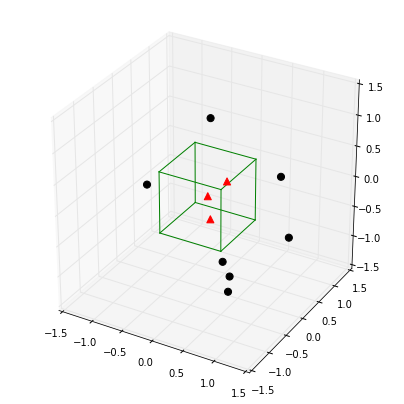

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
ax.set_aspect("equal")

# Plot Points

# samples within the cube
X_inside = np.array([[0,0,0],[0.2,0.2,0.2],[0.1, -0.1, -0.3]])

X_outside = np.array([[-1.2,0.3,-0.3],[0.8,-0.82,-0.9],[1, 0.6, -0.7],
                      [0.8,0.7,0.2],[0.7,-0.8,-0.45],[-0.3, 0.6, 0.9],
                      [0.7,-0.6,-0.8]])

for row in X_inside:
    ax.scatter(row[0], row[1], row[2], color="r", s=50, marker='^')

for row in X_outside:    
    ax.scatter(row[0], row[1], row[2], color="k", s=50)

# Plot Cube
h = [-0.5, 0.5]
for s, e in combinations(np.array(list(product(h,h,h))), 2):
    if np.sum(np.abs(s-e)) == h[1]-h[0]:
        ax.plot3D(*zip(s,e), color="g")
        
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)

plt.show()

In [12]:
point_x = np.array([[0],[0],[0]])
X_all = np.vstack((X_inside,X_outside))

print('p(x) =', parzen_estimation(X_all, point_x, h=1))

p(x) = 0.3


<br>
<br>

## Sample data and `timeit` benchmarks

[[back to top](#Sections)]

In the section below, we will create a random dataset from a bivariate Gaussian distribution with a mean vector centered at the origin and a identity matrix as covariance matrix. 

In [13]:
import numpy as np

np.random.seed(123)

# Generate random 2D-patterns
mu_vec = np.array([0,0])
cov_mat = np.array([[1,0],[0,1]])
x_2Dgauss = np.random.multivariate_normal(mu_vec, cov_mat, 10000)

The expected probability of a point at the center of the distribution is ~ 0.15915 as we can see below.  
And our goal is here to use the Parzen-window approach to predict this density based on the sample data set that we have created above.  


In order to make a "good" prediction via the Parzen-window technique, it is - among other things - crucial to select an appropriate window with. Here, we will use multiple processes to predict the density at the center of the bivariate Gaussian distribution using different window widths.

In [14]:
from scipy.stats import multivariate_normal
var = multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]])
print('actual probability density:', var.pdf([0,0]))

actual probability density: 0.159154943092


<br>
<br>

## Benchmarking functions

[[back to top](#Sections)]

Below, we will set up benchmarking functions for our serial and multiprocessing approach that we can pass to our `timeit` benchmark function.  
We will be using the `Pool.apply_async` function to take advantage of firing up processes simultaneously: Here, we don't care about the order in which the results for the different window widths are computed, we just need to associate each result with the input window width.  
Thus we add a little tweak to our Parzen-density-estimation function by returning a tuple of 2 values: window width and the estimated density, which will allow us to sort our list of results later.

In [15]:
def parzen_estimation(x_samples, point_x, h):
    k_n = 0
    for row in x_samples:
        x_i = (point_x - row[:,np.newaxis]) / (h)
        for row in x_i:
            if np.abs(row) > (1/2):
                break
        else: # "completion-else"*
            k_n += 1
    return (h, (k_n / len(x_samples)) / (h**point_x.shape[1]))

In [16]:
def serial(samples, x, widths):
    return [parzen_estimation(samples, x, w) for w in widths]

def multiprocess(processes, samples, x, widths):
    pool = mp.Pool(processes=processes)
    results = [pool.apply_async(parzen_estimation, args=(samples, x, w)) for w in widths]
    results = [p.get() for p in results]
    results.sort() # to sort the results by input window width
    return results

Just to get an idea what the results would look like (i.e., the predicted densities for different window widths):

In [17]:
widths = np.arange(0.1, 1.3, 0.1)
point_x = np.array([[0],[0]])
results = []

results = multiprocess(4, x_2Dgauss, point_x, widths)

for r in results:
    print('h = %s, p(x) = %s' %(r[0], r[1]))

h = 0.1, p(x) = 0.016
h = 0.2, p(x) = 0.0305
h = 0.3, p(x) = 0.045
h = 0.4, p(x) = 0.06175
h = 0.5, p(x) = 0.078
h = 0.6, p(x) = 0.0911666666667
h = 0.7, p(x) = 0.106
h = 0.8, p(x) = 0.117375
h = 0.9, p(x) = 0.132666666667
h = 1.0, p(x) = 0.1445
h = 1.1, p(x) = 0.157090909091
h = 1.2, p(x) = 0.1685


Based on the results, we can say that the best window-width would be h=1.1, since the estimated result is close to the actual result ~0.15915.  
Thus, for the benchmark, let us create 100 evenly spaced window width in the range of 1.0 to 1.2.

<br>
<br>

In [18]:
widths = np.linspace(1.0, 1.2, 100)

In [19]:
import timeit

mu_vec = np.array([0,0])
cov_mat = np.array([[1,0],[0,1]])
n = 10000

x_2Dgauss = np.random.multivariate_normal(mu_vec, cov_mat, n)

benchmarks = []

benchmarks.append(timeit.Timer('serial(x_2Dgauss, point_x, widths)', 
            'from __main__ import serial, x_2Dgauss, point_x, widths').timeit(number=1))

benchmarks.append(timeit.Timer('multiprocess(2, x_2Dgauss, point_x, widths)', 
            'from __main__ import multiprocess, x_2Dgauss, point_x, widths').timeit(number=1))

benchmarks.append(timeit.Timer('multiprocess(3, x_2Dgauss, point_x, widths)', 
            'from __main__ import multiprocess, x_2Dgauss, point_x, widths').timeit(number=1))

benchmarks.append(timeit.Timer('multiprocess(4, x_2Dgauss, point_x, widths)', 
            'from __main__ import multiprocess, x_2Dgauss, point_x, widths').timeit(number=1))

benchmarks.append(timeit.Timer('multiprocess(6, x_2Dgauss, point_x, widths)', 
            'from __main__ import multiprocess, x_2Dgauss, point_x, widths').timeit(number=1))

<br>
<br>

## Preparing the plotting of the results

[[back to top](#Sections)]

In [20]:
import platform

def print_sysinfo():
    
    print('\nPython version  :', platform.python_version())
    print('compiler        :', platform.python_compiler())
    
    print('\nsystem     :', platform.system())
    print('release    :', platform.release())
    print('machine    :', platform.machine())
    print('processor  :', platform.processor())
    print('CPU count  :', mp.cpu_count())
    print('interpreter:', platform.architecture()[0])
    print('\n\n')

In [25]:
from matplotlib import pyplot as plt
import numpy as np

def plot_results():
    bar_labels = ['serial', '2', '3', '4', '6']

    fig = plt.figure(figsize=(10,8))

    # plot bars
    y_pos = np.arange(len(benchmarks))
    plt.yticks(y_pos, bar_labels, fontsize=16)
    bars = plt.barh(y_pos, benchmarks,
             align='center', alpha=0.4, color='g')

    # annotation and labels
    
    for ba,be in zip(bars, benchmarks):
        plt.text(ba.get_width() + 2, ba.get_y() + ba.get_height()/2,
                '{0:.2%}'.format(benchmarks[0]/be), 
                ha='center', va='bottom', fontsize=12)
    
    plt.xlabel('time in seconds for n=%s' %n, fontsize=14)
    plt.ylabel('number of processes', fontsize=14)
    t = plt.title('Serial vs. Multiprocessing via Parzen-window estimation', fontsize=18)
    plt.ylim([-1,len(benchmarks)+0.5])
    plt.xlim([0,max(benchmarks)*1.1])
    plt.vlines(benchmarks[0], -1, len(benchmarks)+0.5, linestyles='dashed')
    plt.grid()

    plt.show()

<br>
<br>

# Results

[[back to top](#Sections)]

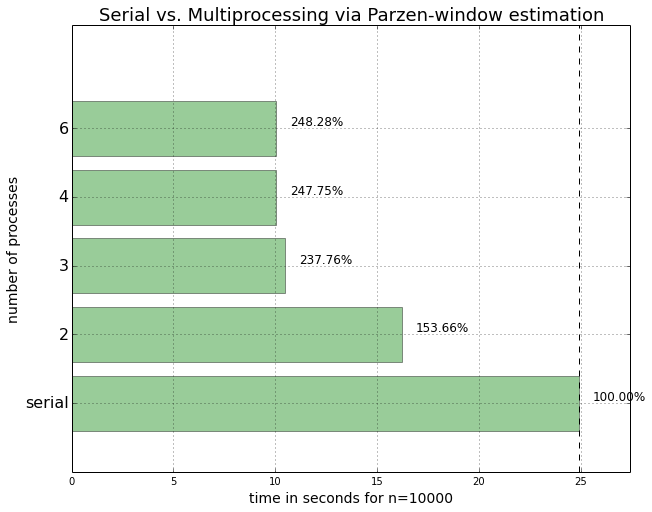


Python version  : 3.4.1
compiler        : GCC 4.2.1 (Apple Inc. build 5577)

system     : Darwin
release    : 13.2.0
machine    : x86_64
processor  : i386
CPU count  : 4
interpreter: 64bit





In [26]:
plot_results()
print_sysinfo()

<br>
<br>

# Conclusion

[[back to top](#Sections)]

We can see that we could speed up the density estimations for our Parzen-window function if we submitted them in parallel. However, on my particular machine, the submission of 6 parallel 6 processes doesn't lead to a further performance improvement, which makes sense for a 4-core CPU.  
We also notice that there was a significant performance increase when we were using 3 instead of only 2 processes in parallel. However, the performance increase was less significant when we moved up to 4 parallel processes, respectively.  
This can be attributed to the fact that in this case, the CPU consists of only 4 cores, and system processes, such as the operating system, are also running in the background. Thus, the fourth core simply does not have enough capacity left to further increase the performance of the fourth process to a large extend. And we also have to keep in mind that every additional process comes with an additional overhead for inter-process communication.  

Also, an improvement due to parallel processing only makes sense if our tasks are "CPU-bound" where the majority of the task is spent in the CPU in contrast to I/O bound tasks, i.e., tasks that are processing data from a disk. 